# Expectation and Maximization Algorithm

This is a Notebook based on the original found at https://github.com/ajcr/em-explanation/blob/master/em-notebook-2.ipynb. I've added and modified the code here and there, but primary credits go to the original author.

I highly recommend reading our guide on EM algorithm (https://skytowner.com/explore/expectation_maximisation) to understand the code in more depth.

We first begin by importing the necessary libraries:

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn')

We then generate 20 samples from two different Normal distribution each.

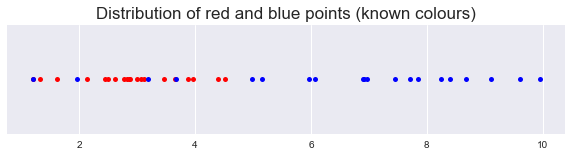

In [95]:
# For reproducible results
np.random.seed(2000)

# Set the parameters for red and blue distributions we will draw from
red_mean = 3
red_std = 0.8
blue_mean = 7
blue_std = 2

# Draw 20 samples from each normal distribution
red_sample = np.random.normal(red_mean, red_std, size=20)
blue_sample = np.random.normal(blue_mean, blue_std, size=20)

# Plot the one-dimensional plot showing the samples and which distribution they actually belong to
plt.rcParams['figure.figsize'] = (10, 2)
plt.plot(red_sample, np.zeros_like(red_sample), '.', color='r', markersize=10);
plt.plot(blue_sample, np.zeros_like(blue_sample), '.', color='b', markersize=10);
plt.title(r'Distribution of red and blue points (known colours)', fontsize=17);
plt.yticks([]);

Although we know the exact parameters of the Normal distribution that generated our dataset, we now pretend as if we do not so that we can turn this into a clustering problem. In other words, we remove the coloring, and our goal is to estimate the parameters of the two Normal distributions.

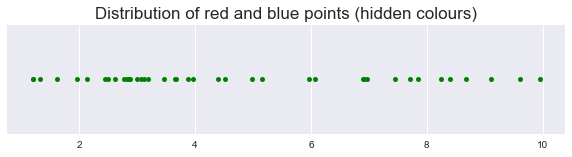

In [98]:
# A sorted array of size 40 that contains the total sample
# Sorting just makes our explanations easier
total_sample = np.sort(np.concatenate((red_sample, blue_sample)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.plot(total_sample, np.zeros_like(total_sample), '.', color='g', markersize=10);
plt.title(r'Distribution of red and blue points (hidden colours)', fontsize=17);
plt.yticks([]);

## Step one: Set initial estimates of parameters
Begin with an initial estimate of the means and standard deviations of the two distributions.

In [87]:
# Estimates for the mean
red_mean_guess = 1.1
blue_mean_guess = 9

# Estimates for the standard deviation
red_std_guess = 2
blue_std_guess = 1.7

We define a method to plot the two plot bell curves given the their parameters:

In [155]:
def plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=1, to_show_hidden_colors=True, to_show_colors=True, mask_likelihood=[]):
    
    plt.rcParams['figure.figsize'] = (10, 4)
    
    if to_show_colors:
        if to_show_hidden_colors:
            plt.plot(total_sample, np.zeros_like(total_sample), '.', color='g', markersize=10)
        elif len(mask_likelihood) > 0:
            predicted_reds = total_sample[mask_likelihood]
            predicted_blues = total_sample[~mask_likelihood]
            plt.plot(predicted_reds, np.zeros_like(predicted_reds), '.', color='r', markersize=15);
            plt.plot(predicted_blues, np.zeros_like(predicted_blues), '.', color='b', markersize=15);
        else:
            plt.plot(red_sample, np.zeros_like(red_sample), '.', color='r', markersize=15);
            plt.plot(blue_sample, np.zeros_like(blue_sample), '.', color='b', markersize=15);

    # Obtain the lower bound and upper bound for plotting purposes
    lower_bound = np.floor(total_sample.min()) - 1
    upper_bound = np.ceil(total_sample.max()) + 1
    x = np.linspace(lower_bound, upper_bound, 1000)
    
    # Plot the bell curves
    plt.plot(x, stats.norm(red_mean_guess, red_std_guess).pdf(x), color='r', alpha=alpha)
    plt.plot(x, stats.norm(blue_mean_guess, blue_std_guess).pdf(x), color='b', alpha=alpha)
    
    # Get the height of the bell curves in order to draw verticle lines indicating the mean
    red_height = stats.norm(red_mean_guess, red_std_guess).pdf(red_mean_guess)
    blue_height = stats.norm(blue_mean_guess, blue_std_guess).pdf(blue_mean_guess)
    plt.vlines(red_mean_guess, 0, red_height, 'r', '--', alpha=alpha)
    plt.vlines(blue_mean_guess, 0, blue_height, 'b', '--', alpha=alpha)

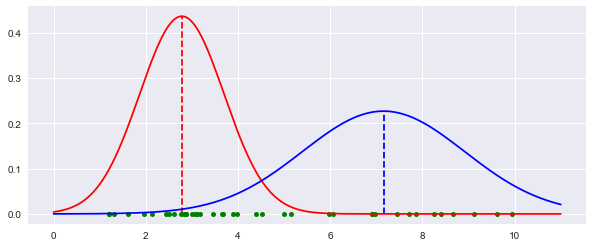

In [153]:
plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess)

## Step two: Computing the likelihood of each data point

Here, we define a helper method to pretty-print NumPy arrays:

In [111]:
def print_head(numpy_arrays, col_names, n=5, to_include_sum=True, sum_label="Total"):
    numpy_matrix = np.column_stack(numpy_arrays)
    df = pd.DataFrame(numpy_matrix, columns=col_names)
    if to_include_sum:
        df[sum_label] = df.iloc[:,0] + df.iloc[:,1]
    print(df.head(n))

In [115]:
likelihood_of_red = stats.norm(red_mean_guess, red_std_guess).pdf(total_sample)
likelihood_of_blue = stats.norm(blue_mean_guess, blue_std_guess).pdf(total_sample)
print_head([likelihood_of_red, likelihood_of_blue], ["Likelihood of Red", "Likelihood of Blue"], sum_label="Total likelihood")

   Likelihood of Red  Likelihood of Blue  Total likelihood
0           0.199257            0.000006          0.199264
1           0.199236            0.000006          0.199242
2           0.198326            0.000009          0.198335
3           0.192793            0.000019          0.192812
4           0.181693            0.000045          0.181738


Note that the points 0 ~ N are sorted from left to right. The above output makes intuitive sense, since we would expect the first point to be sampeld from the red normal distribution rather than the blue normal distribution.

## Step three: Computing the likelihood weight of each data point

Define a method to get an NumPy array of values representing the likelihood weight of each data point:

In [183]:
def get_likelihood_weight(colour_likelihood, total_likelihood):
    return colour_likelihood / total_likelihood

In [184]:
total_likelihood = likelihood_of_red + likelihood_of_blue

red_weights = get_likelihood_weight(likelihood_of_red, total_likelihood)
blue_weights = get_likelihood_weight(likelihood_of_blue, total_likelihood)

print_head([red_weights, blue_weights], ["Red Weights", "Blue Weights"], to_include_sum=False)

   Red Weights  Blue Weights
0     0.992577      0.007423
1     0.992576      0.007424
2     0.992502      0.007498
3     0.991859      0.008141
4     0.990179      0.009821


Again, this should be quite intuitive. The first few points have high red weights since it is very likely that the source of the sample is the red normal distribution.

## Step four: Proposing new values for parameters

Define methods to estimate new sets of mean and standard deviation. Please refer to our guide at https://skytowner.com/explore/expected_maximisation for an explanation.

In [120]:
def estimate_mean(both_colours, color_weights):
    return np.sum(both_colours * color_weights) / np.sum(color_weights)

def estimate_std(both_colours, color_weights, current_color_mean):
    variance = np.sum(color_weights * (both_colours - current_color_mean)**2) / np.sum(color_weights)
    return np.sqrt(variance)

In [121]:
red_std_guess = estimate_std(total_sample, red_weights, red_mean_guess)
blue_std_guess = estimate_std(total_sample, blue_weights, blue_mean_guess)

red_mean_guess = estimate_mean(total_sample, red_weights)
blue_mean_guess = estimate_mean(total_sample, blue_weights)

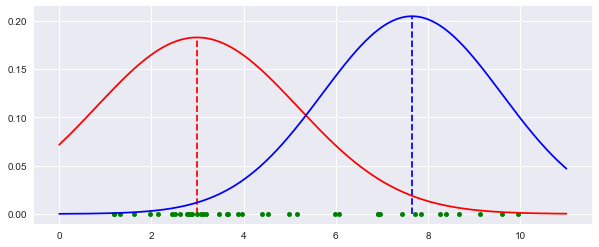

In [124]:
# Plot the the distributions with the newly estimated parameters
plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess)

## Bringing everything together
The method below performs the entire EM algorithm, which combines steps 1 to 5 in an iterative manner.

In [130]:
def perform_EM():
    
    # Estimates for the mean
    red_mean_guess = 1.1
    red_std_guess = 2

    # Estimates for the standard deviation
    blue_mean_guess = 9
    blue_std_guess = 1.7
    
    # Number of iterations of EM
    N_ITER = 20
    
    # Transparency of curves to plot for each iteration
    alphas = np.linspace(0.2, 1, N_ITER)
    
    # Plot initial estimates
    plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=0.13)

    for i in range(N_ITER):
    
        ######################## Expectation step ########################
        likelihood_of_red = stats.norm(red_mean_guess, red_std_guess).pdf(total_sample)
        likelihood_of_blue = stats.norm(blue_mean_guess, blue_std_guess).pdf(total_sample)
        total_likelihood = likelihood_of_red + likelihood_of_blue

        red_weights = weight_of_colour(likelihood_of_red, total_likelihood)
        blue_weights = weight_of_colour(likelihood_of_blue, total_likelihood)
        
        ######################## Maximization step ########################
        red_std_guess = estimate_std(total_sample, red_weights, red_mean_guess)
        blue_std_guess = estimate_std(total_sample, blue_weights, blue_mean_guess)

        red_mean_guess = estimate_mean(total_sample, red_weights)
        blue_mean_guess = estimate_mean(total_sample, blue_weights)

        if i == N_ITER - 1:
            print("Red mean: " + str(red_mean_guess))
            print("Red Standard Deviation: " + str(red_std_guess))
            print("Blue mean: " + str(blue_mean_guess))
            print("Blue Standard Deviation: " + str(blue_std_guess))
            print("************************")
            print("Error for Red Mean: " + str(red_mean_guess - red_mean))
            print("Error for Red Standard Deviation: " + str(red_std_guess - red_std))
            print("Error for Blue mean: " + str(blue_mean_guess - blue_mean))
            print("Error for Blue Standard Deviation: " + str(blue_std_guess - blue_std))
            return red_mean_guess, red_std_guess, blue_mean_guess, blue_std_guess, likelihood_of_red, likelihood_of_blue
        
        plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=alphas[i], to_show_colors=False)
        
    plt.title(r'Estimates of group distributions after {} iterations of Expectation Maximisation'.format(N_ITER), 
    fontsize=17);

Red mean: 2.782033799269119
Red Standard Deviation: 0.9147253393014972
Blue mean: 7.154831033813396
Blue Standard Deviation: 1.7591488211285824
************************
Error for Red Mean: -0.2179662007308809
Error for Red Standard Deviation: 0.1147253393014972
Error for Blue mean: 0.15483103381339625
Error for Blue Standard Deviation: -0.2408511788714176


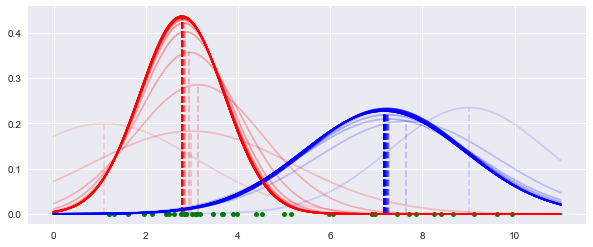

In [131]:
red_mean_guess, red_std_guess, blue_mean_guess, blue_std_guess, likelihood_of_red, likelihood_of_blue = perform_EM()

The performance is actually great. We only ran our algorithm 20 times, and have ultiamtely reached the a small error for our estimates.

We now print out the final likelihood values of the red and blue for the first 3 data points:

In [180]:
# Suppress scientific notation
np.set_printoptions(suppress=True)
print("Likelihood values of red:", likelihood_of_red[:3])
print("Likelihood values of blue:", likelihood_of_blue[:3])

Likelihood values of red: [0.09636563 0.09719281 0.12041066]
Likelihood values of blue: [0.00072063 0.00072692 0.0009096 ]


After the EM algorithm, we end up with well-defined normal distributions with estimated parameters. We can then compute the likelihood values once again, and check which distribution each data point belongs to.

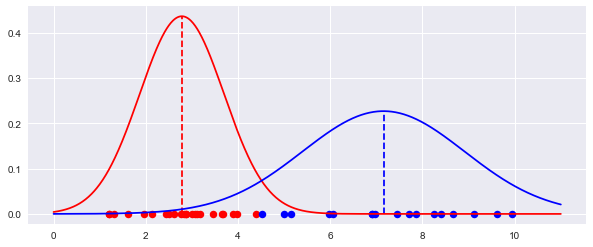

In [185]:
# Obtain a mask of booleans where
# - True means the data point is more likely to come from the red distribution
# - False means that the data point is more likely to come from the blue distribution
mask_likelihood = likelihood_of_red > likelihood_of_blue
plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, to_show_hidden_colors=False, mask_likelihood=mask_likelihood)